In [1]:
# set up logging
import logging
logging.basicConfig(
        format="%(asctime)s - %(levelname)s - %(name)s -   %(message)s",
        datefmt="%m/%d/%Y %H:%M:%S",
        level=logging.INFO,
)

In [2]:
# make deterministic
from mingpt.utils import set_seed
set_seed(42)

In [3]:
import numpy as np
import torch
import torch.nn as nn
from torch.nn import functional as F

In [4]:
# config
embeddingSize=512
numPoints=100 # number of points that we are going to receive to make a prediction about f given x and y
numVars=3 # the dimenstion of input points x
numYs=1 # the dimension of output points y = f(x)
blockSize = 60 # spatial extent of the model for its context
batchSize = 256
dataInfo = 'XYE_3Var_100Points'

In [5]:
import math
from torch.utils.data import Dataset

class CharDataset(Dataset):

    def __init__(self, data, block_size, chars):
        data_size, vocab_size = len(data), len(chars)
        print('data has %d examples, %d unique.' % (data_size, vocab_size))
        
        self.stoi = { ch:i for i,ch in enumerate(chars) }
        self.itos = { i:ch for i,ch in enumerate(chars) }
        
        # padding token
        self.paddingToken = '_'
        self.paddingID = self.stoi[self.paddingToken]
        self.stoi[self.paddingToken] = self.paddingID
        self.itos[self.paddingID] = self.paddingToken
        self.threshold = [-1000,1000]
        
        self.block_size = block_size
        self.vocab_size = vocab_size
        self.data = data # it should be a list of examples
    
    def __len__(self):
        return len(self.data)-1

    def __getitem__(self, idx):
        # grab an example from the data
        chunk = self.data[idx] # sequence of tokens including x, y, eq, etc.
        chunk = json.loads(chunk) # convert the sequence tokens to a dictionary
        
        # encode every character in the equation to an integer
        # < is SOS, > is EOS
        dix = [self.stoi[s] for s in '<'+chunk['EQ']+'>']
        inputs = dix[:-1]
        outputs = dix[1:]
        
        # add the padding to the equations
        paddingSize = max(self.block_size-len(inputs),0)
        paddingList = [self.paddingID]*paddingSize
        inputs += paddingList
        outputs += paddingList 
        
        # make sure it is not more than what should be
        inputs = inputs[:self.block_size]
        outputs = outputs[:self.block_size]
        
        # extract points from the input sequence
        points = torch.zeros(numVars+numYs, numPoints)
        for idx, xy in enumerate(zip(chunk['X'], chunk['Y'])):
            x = xy[0] + [0]*(max(numVars-len(xy[0]),0)) # padding
            y = [xy[1]] if type(xy[1])== float else xy[1]
            y = y + [0]*(max(numYs-len(y),0)) # padding
            p = x+y # because it is only one point 
            p = torch.tensor(p)
            #replace nan and inf
            p = torch.nan_to_num(p, nan=0.0, 
                                 posinf=self.threshold[1], 
                                 neginf=self.threshold[0])
            p[p>self.threshold[1]] = self.threshold[1] # clip the upper bound
            p[p<self.threshold[0]] = self.threshold[0] # clip the lower bound
            points[:,idx] = p
        
        """
        arrange data and targets so that the first i elements of x
        will be asked to predict the i-th element of y. Notice that
        the eventual language model will actually make block_size
        individual predictions at the same time based on this data,
        so we are being clever and amortizing the cost of the forward
        pass of the network. So for example if block_size is 4, then
        we could e.g. sample a chunk of text "hello", the integers in
        x will correspond to "hell" and in y will be "ello". This will
        then actually "multitask" 4 separate examples at the same time
        in the language model:
        - given just "h", please predict "e" as next
        - given "he" please predict "l" next
        - given "hel" predict "l" next
        - given "hell" predict "o" next
        
        In addition, because the DataLoader will create batches of examples,
        every forward/backward pass during traning will simultaneously train
        a LOT of predictions, amortizing a lot of computation. In particular,
        for a batched input of integers X (B, T) where B is batch size and
        T is block_size and Y (B, T), the network will during training be
        simultaneously training to make B*T predictions, all at once! Of course,
        at test time we can paralellize across batch B, but unlike during training
        we cannot parallelize across the time dimension T - we have to run
        a forward pass of the network to recover the next single character of the 
        sequence along each batch dimension, and repeatedly always feed in a next
        character to get the next one.
        
        So yes there is a big asymmetry between train/test time of autoregressive
        models. During training we can go B*T at a time with every forward pass,
        but during test time we can only go B at a time, T times, with T forward 
        passes.
        """
        inputs = torch.tensor(inputs, dtype=torch.long)
        outputs = torch.tensor(outputs, dtype=torch.long)
        return inputs, outputs, points


In [6]:
import json
from tqdm import tqdm
import glob
def processDataFiles(files):
    text = ''""
    for f in tqdm(files):
        with open(f, 'r') as h: 
            lines = h.read() # don't worry we won't run out of file handles
            text += lines #json.loads(line)                
    return text

In [7]:
#path = 'D:\Datasets\Symbolic Dataset\Datasets\Mesh_Simple_GPT2_Sorted\TrainDatasetFixed\*.json'
path = 'D:/Datasets/Symbolic Dataset/Datasets/3Var_-3to3_3.1to10/Train/*.json'
files = glob.glob(path)
text = processDataFiles(files)
chars = sorted(list(set(text))+['_','T','<','>']) # extract unique characters from the text before converting the text to a list
# T is for the test data
text = text.split('\n') # convert the raw text to a set of examples
train_dataset = CharDataset(text, blockSize, chars) 

100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [01:37<00:00,  8.82s/it]


data has 2842610 examples, 51 unique.


In [8]:
idx = np.random.randint(train_dataset.__len__())
inputs, outputs, points = train_dataset.__getitem__(idx)
print('inputs:{}'.format(inputs))
inputs = ''.join([train_dataset.itos[int(i)] for i in inputs])
outputs = ''.join([train_dataset.itos[int(i)] for i in outputs])
print('id:{}\ninputs:{}\noutputs:{}\npoints:{}'.format(idx,inputs,outputs,points))

inputs:tensor([22, 45, 37, 40,  3, 39, 41, 36,  3, 47, 14,  6, 13,  9, 17, 12,  4,  4,
        33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33,
        33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33,
        33, 33, 33, 33, 33, 33])
id:2219110
inputs:<sin(log(x3+2.61))__________________________________________
outputs:sin(log(x3+2.61))>__________________________________________
points:tensor([[ 0.1300, -0.0800,  1.7100,  1.6800,  1.7900, -2.4800, -0.6100,  0.2000,
         -2.4100,  0.4700, -2.9300, -2.5100,  2.1400, -2.2800,  0.7200,  0.4000,
         -1.3700, -2.1000,  0.9800,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000

In [9]:
#path = 'D:\Datasets\Symbolic Dataset\Datasets\Mesh_Simple_GPT2_Sorted\TestDataset\*.json'
path = 'D:/Datasets/Symbolic Dataset/Datasets/3Var_-3to3_3.1to10/Test/*.json'
files = glob.glob(path)
textTest = processDataFiles([files[0]])
textTest = textTest.split('\n') # convert the raw text to a set of examples
test_dataset = CharDataset(textTest, blockSize, chars)

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18.21it/s]

data has 1001 examples, 51 unique.


In [10]:
idx = np.random.randint(test_dataset.__len__())
inputs, outputs, points = train_dataset.__getitem__(idx)
print(points.min(), points.max())
inputs = ''.join([train_dataset.itos[int(i)] for i in inputs])
outputs = ''.join([train_dataset.itos[int(i)] for i in outputs])
print('id:{}\ninputs:{}\noutputs:{}\npoints:{}'.format(idx,inputs,outputs,points))

tensor(-1000.) tensor(1000.)
id:435
inputs:<x1+4.82*x3-2.97*exp(3.76*x1)_______________________________
outputs:x1+4.82*x3-2.97*exp(3.76*x1)>_______________________________
points:tensor([[-1.7800e+00,  2.5700e+00, -9.2000e-01,  1.1800e+00,  1.3100e+00,
         -1.0000e+00,  1.5700e+00, -1.4700e+00, -2.7200e+00,  2.8500e+00,
          1.6400e+00,  2.8900e+00, -2.6000e-01,  1.4200e+00,  5.0000e-01,
          2.3500e+00, -1.0100e+00, -9.1000e-01, -1.0600e+00, -2.1000e+00,
         -1.5000e+00,  2.3600e+00,  1.0500e+00, -4.0000e-01,  1.0400e+00,
         -1.3000e+00,  1.1000e+00, -2.0600e+00, -1.6300e+00, -6.5000e-01,
          1.9000e+00,  1.4000e+00,  7.2000e-01,  3.2000e-01, -1.0500e+00,
         -2.3200e+00,  2.2800e+00, -2.8000e+00,  8.1000e-01, -2.0000e-02,
          2.7000e-01,  8.1000e-01, -6.8000e-01, -1.6800e+00,  7.2000e-01,
         -4.3000e-01, -2.5500e+00, -5.2000e-01, -6.2000e-01,  2.6300e+00,
          4.5000e-01,  7.3000e-01, -1.6700e+00, -2.5400e+00, -1.8000e-01,
      

In [11]:
from mingpt.model import GPT, GPTConfig, PointNetConfig
pconf = PointNetConfig(embeddingSize=embeddingSize, 
                       numberofPoints=numPoints, 
                       numberofVars=numVars, 
                       numberofYs=numYs)
mconf = GPTConfig(train_dataset.vocab_size, train_dataset.block_size,
                  n_layer=8, n_head=8, n_embd=embeddingSize, padding_idx=train_dataset.paddingID)
model = GPT(mconf, pconf)

05/21/2021 21:29:17 - INFO - mingpt.model -   number of parameters: 3.056334e+07


In [13]:
from mingpt.trainer import Trainer, TrainerConfig

# initialize a trainer instance and kick off training
tconf = TrainerConfig(max_epochs=50, batch_size=batchSize, learning_rate=6e-4,
                      lr_decay=True, warmup_tokens=512*20, final_tokens=2*len(train_dataset)*blockSize,
                      num_workers=0, ckpt_path='./SavedModels/bestModel/checkpoint.pt')
trainer = Trainer(model, train_dataset, test_dataset, tconf)

try:
    trainer.train()
except KeyboardInterrupt:
    print('KeyboardInterrupt')

epoch 1 iter 3: train loss 0.67337. lr 6.000000e-04:   0%|                         | 4/11104 [00:11<8:48:34,  2.86s/it]

KeyboardInterrupt


In [ ]:
# model.load_state_dict(torch.load('./SavedModels/bestModel/checkpoint.pt'))
# model = model.eval().to(trainer.device)

In [14]:
# add a safe wrapper for numpy math functions
from numpy import *
import numpy as np

def divide(x, y):
  x = np.nan_to_num(x)
  y = np.nan_to_num(y)
  return np.divide(x,y+1e-5)

def sqrt(x):
  x = np.nan_to_num(x)
  return np.sqrt(np.abs(x)) 

# Mean square error
def mse(y, y_hat):
    y_hat = np.reshape(y_hat, [1, -1])[0]
    y_gold = np.reshape(y, [1, -1])[0]
    our_sum = 0
    for i in range(len(y_gold)):
        our_sum += (y_hat[i] - y_gold[i]) ** 2

    return our_sum / len(y_gold)

# Mean square error
def relativeErr(y, y_hat):
    y_hat = np.reshape(y_hat, [1, -1])[0]
    y_gold = np.reshape(y, [1, -1])[0]
    our_sum = 0
    for i in range(len(y_gold)):
        if y_gold[i] < 1: 
            # use regular MSE
            our_sum += (y_hat[i] - y_gold[i]) ** 2
        else:
            # use relative MSE
            our_sum += ((y_hat[i] - y_gold[i])/y_gold[i]) ** 2

    return our_sum / len(y_gold)

In [15]:
fName = '{}_SymbolicGPT_{}_{}_{}.txt'.format(dataInfo, 
                                             'GPT_PT_Summation', 
                                             'Padding',
                                             blockSize)

In [16]:
# alright, let's sample some character-level symbolic GPT
from mingpt.utils import sample
from gp_model import Genetic_Model
from mlp_model import MLP_Model
    
loader = torch.utils.data.DataLoader(
                                test_dataset, 
                                shuffle=False, 
                                pin_memory=True,
                                batch_size=1,
                                num_workers=0)

testRange = [3.1,6.0]
numTestPoints = 10
#test = np.linspace(3.1,6.0,numTestPoints)

gpm = Genetic_Model(n_jobs=-1)
mlp = MLP_Model()

resultDict = {}
with open(fName, 'w', encoding="utf-8") as o:
    modelName = 'SymbolicGPT'
    resultDict[fName] = {modelName:[],
                         'GP':[],
                         'MLP':[]}
    
    for i, batch in enumerate(loader):
        inputs,outputs,points = batch
        
        print('Test Case {}.'.format(i))
        o.write('Test Case {}/{}.\n'.format(i,len(textTest)))
        
        t = json.loads(textTest[i])
        
        inputs = inputs[:,0:1].to(trainer.device)
        points = points.to(trainer.device)
        outputsHat = sample(model, inputs, blockSize, points=points,
                      temperature=1.0, sample=True, 
                      top_k=10)[0]
            
        # filter out predicted
        target = ''.join([train_dataset.itos[int(i)] for i in outputs[0]])
        predicted = ''.join([train_dataset.itos[int(i)] for i in outputsHat])
        
#         if i == 31:
#             raise
#         else:
#             continue
        
        #print(target, predicted)
        #raise

        target = target.strip(train_dataset.paddingToken).split('>')
        target = target[0] if len(target[0])>=1 else target[1]
        target = target.strip('<').strip(">")
        predicted = predicted.strip(train_dataset.paddingToken).split('>')
        predicted = predicted[0] if len(predicted[0])>=1 else predicted[1]
        predicted = predicted.strip('<').strip(">")
       
        o.write('{}\n'.format(target))
        
        print('Target:{}\nOurs: {}'.format(target, predicted))
        
        Ys = [] #t['YT']
        Yhats = []
        for xs in t['XT']:
            try:
                eqTmp = target + '' # copy eq
                eqTmp = eqTmp.replace(' ','')
                eqTmp = eqTmp.replace('\n','')
                for i,x in enumerate(xs):
                    # replace xi with the value in the eq
                    eqTmp = eqTmp.replace('x{}'.format(i+1), str(x))
                    if ',' in eqTmp:
                        assert 'There is a , in the equation!'
                YEval = eval(eqTmp)
                YEval = 0 if np.isnan(YEval) else YEval
                YEval = 100 if np.isinf(YEval) else YEval
            except:
                YEval = 100 #TODO: Maybe I have to punish the model for each wrong template not for each point
            Ys.append(YEval)
            try:
                eqTmp = predicted + '' # copy eq
                eqTmp = eqTmp.replace(' ','')
                eqTmp = eqTmp.replace('\n','')
                for i,x in enumerate(xs):
                    # replace xi with the value in the eq
                    eqTmp = eqTmp.replace('x{}'.format(i+1), str(x))
                    if ',' in eqTmp:
                        assert 'There is a , in the equation!'
                Yhat = eval(eqTmp)
                Yhat = 0 if np.isnan(Yhat) else Yhat
                Yhat = 100 if np.isinf(Yhat) else Yhat
            except:
                Yhat = 100
            Yhats.append(Yhat)
        err = relativeErr(Ys,Yhats)
        
        if type(err) is np.complex128 or np.complex:
            err = abs(err.real)
            
        resultDict[fName][modelName].append(err)
        
        o.write('{}:{}\n{}\n\n'.format(modelName, 
                               err,
                               predicted))
        
        print('Err:{}'.format(err))
        
#         # tokenize to get input x, input y, and true eqn
#         train_data_x = t["X"]
#         train_data_y = t["Y"]
#         test_data_x = t["XT"]
#         test_data_y = t["YT"]

#         # train MLP model
#         mlp.reset()
#         model_eqn, _, best_err = mlp.repeat_train(
#                                                 train_data_x, 
#                                                 train_data_y,
#                                                 test_x=test_data_x, 
#                                                 test_y=test_data_y,                                     
#                                                 verbose=False)
#         test_y_hat = mlp.predict(test_data_x)
#         err = relativeErr(test_data_y,test_y_hat)
#         print("{}: {}".format(mlp.name, model_eqn)[:550])
#         print("Err: {:.5f}".format(err))
#         resultDict[fName]['MLP'].append(err)
#         o.write('\n{}: {}\n{}'.format('MLP', 
#                                    err,
#                                    model_eqn))

#         # train GPL model
#         gpm.reset()
#         model_eqn, _, best_err = gpm.repeat_train(train_data_x, train_data_y,
#                                                 test_x=test_data_x, test_y=test_data_y,
#                                                 verbose=False)
#         print("{}: {}".format(gpm.name, model_eqn)[:550])
#         test_y_hat = gpm.predict(test_data_x)
#         err = relativeErr(test_data_y,test_y_hat)
#         print("Err: {:.5f}".format(err))
#         resultDict[fName]['GP'].append(err)
#         o.write('\n{}: {}\n{}'.format('GP', 
#                                    err,
#                                    model_eqn))
        print('') # just an empty line
print('Avg Err:{}'.format(np.mean(resultDict[fName][modelName])))

Test Case 0.
Target:-3.72*x3+0.01*exp(2.53*x1)
Ours: -1.84*x3+0.25*exp(1.28*x1)
Err:0.9150281953041969

Test Case 1.
Target:sin(2.2*sqrt(x3+0.26))
Ours: sin(-1.02*x1+2.09*sqrt(x3-0.72)
Err:10077.30881458042

Test Case 2.
Target:sqrt(log(4.99*x3-1.07))
Ours: sin(log(x1-3.28))
Err:0.5751885148309424

Test Case 3.


C:\Users\vpcom\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in log
  """Entry point for launching an IPython kernel.


Target:-4.05*x2-0.5*exp(-0.14*x2)
Ours: 0.41*sqrt(exp(-1.14*x2))
Err:394.8679075687092

Test Case 4.
Target:sin(exp(-1.96*x1))
Ours: sin(sin(x1-4.23))
Err:0.4092835772748098

Test Case 5.
Target:log(2.42-4.8*x1)
Ours: sin(0.9*x1+3.34)
Err:0.5351250841496007

Test Case 6.
Target:-167.9*x2*exp(3.55*x1)+4.62
Ours: 2.49*exp(4.03*x1)*exp(-0.68*x2)
Err:8.517935469209944e+28

Test Case 7.
Target:-6.99*x1*x2-5.81*x1+14.85*x2-12.36*sin(0.47*x2-3.59)
Ours: 0.6*x1-3.04*x2
Err:69879.7761187266

Test Case 8.
Target:sin(sin(x2))
Ours: -sin(0.84*x2-1.76)
Err:0.09188757035880203

Test Case 9.
Target:2.57*sqrt(0.31*x1*x3+x1+0.26*x3+0.83)
Ours: x1+3.61
Err:0.027113187409999254

Test Case 10.
Target:2.03*sqrt(-x1-0.27)
Ours: log(2.86-4.48*x2)*log(-0.14*x2-1.58)
Err:1.0

Test Case 11.
Target:log(log(1.1*x1-2.88))
Ours: log(log(1.2*x1-4.55))
Err:0.7499508653244645

Test Case 12.
Target:0.87*x2**2-5.99*x2
Ours: 0.63*sqrt(exp(-3.83*x2))
Err:30.65018125954364

Test Case 13.
Target:-sin(4.34*x2-0.17)
Ours: sin

Target:-4.65*x2+0.67*exp(-4.38*x2)
Ours: sqrt(exp(-4.6*x2))
Err:1074.4232755386427

Test Case 87.
Target:log(exp(2.62*x1))-3.0
Ours: log(x2)+1.37
Err:0.5825656724535447

Test Case 88.
Target:1.41*x2-4.21*x3-0.86*log(x2+4.91)
Ours: -0.81*x2-4.39*x3+2.13*sqrt(-x3-0.21)-2.58
Err:118.34070995702764

Test Case 89.
Target:log(5.02*x1**2-4.8*x1-14.06)
Ours: 2.2*sqrt(1-0.4*x1)*log(2.1-0.48*x1)
Err:1.5775976905410094

Test Case 90.
Target:sin(52.64*exp(4.32*x1))
Ours: -sin(sin(1.35*x1-2.81))
Err:1.350870350884564

Test Case 91.
Target:0.56*sqrt(exp(-3.5*x2))
Ours: sqrt(exp(-1.97*x2))
Err:0.00016287475871785902

Test Case 92.
Target:log(exp(2.43*x3))+3.71
Ours: 2.85*x1+x2+3.68*sin(x1-3.74)
Err:0.2850582388513811

Test Case 93.
Target:exp(-0.31*x2)*exp(0.54*x1*x2)
Ours: exp(-0.42*x2)*exp(0.26*x1*x2)
Err:0.9979334960851647

Test Case 94.
Target:sqrt(log(3.9-3.28*x3))
Ours: log(3.27-0.98*x2)
Err:0.0

Test Case 95.
Target:log(exp(-2.18*x1))+1.02
Ours: log(exp(-1.35*x1))+0.68
Err:25.202747297462686



Target:15.87*x2*sqrt(0.19*x1+1)+0.55
Ours: 4.92*x2**2+16.76*x2+6.0
Err:1.0391023172939429

Test Case 169.
Target:-4.83*x3+4.08+0.1*exp(-3.41*x3)
Ours: -4.26*x3+1.23+exp(-3.28*x3)
Err:1.9580029216555976

Test Case 170.
Target:-15.05*x1*x3*log(1.47*x2+1.24)+6.38*x3
Ours: 10.87*x2**2*sin(1.27*x1-4.77)+12.88*x2+5.47
Err:3190542.1881910767

Test Case 171.
Target:-4.11*x2-2.15*x3+2.05*sqrt(0.24*x3-1)+4.19
Ours: -3.03*x2-1.64*x3+4.67
Err:87.62605136831297

Test Case 172.
Target:-4.17*x3*log(x2-1.23)-1.31
Ours: 2.17*x1*x2+12.64*x1+2.3*x2-0.51*sin(0.54*x2-2.01)
Err:54550.71064634143

Test Case 173.
Target:-sin(0.7*x2+3.21)
Ours: -sin(-0.45*x2+3.61)
Err:0.46213286919056507

Test Case 174.
Target:17.38*x1*x2*x3-0.74*x2-12.48*x3-1.89
Ours: -17.46*x1*x3*log(4.8*x1+1.12)+1.86*x1+15.33*x3-2.5
Err:2.5113542488636074

Test Case 175.
Target:-sin(6.24*x1*x2+10.98*x1-8.1*x2-14.25)
Ours: sin(x1+sin(x1+1.06))
Err:1.063442510586053

Test Case 176.
Target:-sin(-x1+0.59*x3+1.18)
Ours: sin(2.03*x1+2.99*x2+2.5)


C:\Users\vpcom\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:1: RuntimeWarning: overflow encountered in exp
  """Entry point for launching an IPython kernel.


Target:sin(7.06*x2+3.9)
Ours: log(log(x1+3.24))
Err:0.47600150699293087

Test Case 226.
Target:0.81*sqrt(-x2)*sin(1.82*x1)
Ours: -sin(-x1+4.07*x2+3.12)
Err:1.7695906768899696

Test Case 227.
Target:exp(exp(1.77*x1))
Ours: exp(exp(x1))
Err:inf

Test Case 228.


C:\Users\vpcom\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:35: RuntimeWarning: overflow encountered in double_scalars


Target:7.72*sqrt(exp(-0.37*x1))
Ours: -1.11*x1+0.92*sqrt(x3)+9.92
Err:1.0320362042133402

Test Case 229.
Target:log(x1+4.69*x2-1.76)
Ours: log(x2-2.84)-sin(0.06*x2+0.38)
Err:0.7825118449503872

Test Case 230.
Target:-4.56*x2-sin(3.13*x2)-1.22
Ours: -0.25*x1*x2+0.05*x1-2.51*x2+0.42
Err:35.48098421675566

Test Case 231.
Target:log(-2.02*x2+1.44*x3+0.11)
Ours: sin(2.88*x2+2.89)
Err:0.6563803421184315

Test Case 232.
Target:4.17*x1*x2-4.05*x2-0.79*x3+1.37
Ours: 1.01*x1-3.97*x2
Err:1.323596479257481

Test Case 233.
Target:3.63*x2-4.21*x3+0.75
Ours: 4.98*x1*x3+2.81*x1-10.28*x3-1.55*sqrt(-x1)-9.42
Err:25771.38380001521

Test Case 234.
Target:3.02*sqrt(-0.29*x1*x2-x1+0.14*x2+0.47)
Ours: 2.15*sqrt(1-0.94*x1)
Err:0.3748594049351462

Test Case 235.
Target:log(0.9*x1-1)/2+0.33
Ours: 0.25*exp(-1.61*x1)*exp(-0.76*x1**2)
Err:0.9756387936911882

Test Case 236.
Target:log(exp(-2.43*x1))+3.57
Ours: 3.29-1.6*x1
Err:29.61173017364584

Test Case 237.
Target:log(x1-0.84*x3-4.5)
Ours: 4.47*x1*sin(0.04*x1+2.8

C:\Users\vpcom\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:1: RuntimeWarning: overflow encountered in double_scalars
  """Entry point for launching an IPython kernel.


Target:-sin(sin(1.21*x2+1.8))
Ours: sin(sin(x2-1.09))
Err:0.5356916650446792

Test Case 296.
Target:5.54*x1-3.3*x3-4.66
Ours: -4.53*x1**2+4.43*x3+3.53
Err:947.6204543365598

Test Case 297.
Target:5.97*exp(-0.99*x1)
Ours: -2.54*x1*log(1.67-2.23*x3)+3.64
Err:0.0006618637424401569

Test Case 298.
Target:exp(x3)*log(x1+3.46)
Ours: 0.57*x3**2
Err:0.9534980149070491

Test Case 299.
Target:sin(0.52*exp(x3))
Ours: sin(sin(x1+0.7))
Err:1.3211017509798124

Test Case 300.
Target:4.98*x2*log(x1-1.18)
Ours: -2.71*x2*sin(x1+2.75)
Err:1.0664254010044933

Test Case 301.
Target:-log(1.55-3.87*x3)*sin(3.91*x3)
Ours: -1.52*sqrt(-x3)*sin(3.45*x1-2.15)
Err:7.918293118315709

Test Case 302.
Target:1.2*(-x3-0.24)**(1/4)
Ours: in(0.1*x1-4.86)
Err:73.12790475287781

Test Case 303.
Target:log(1.49*x3-1.93)
Ours: log(0.44*x3-1.34)-sin(1.13*x3)
Err:1.439127997902589

Test Case 304.
Target:-9.29*x1*x2-2.63*x1-1.04*x2*x3-6.89*x2-2.5*x3+6.91
Ours: -6.5*x1*x2-4.91*x1-3.16*x2+6.04
Err:41209.947810363476

Test Case 305

Target:-0.46*x1+3.61*x3+5.69
Ours: -0.06*x2+1.1*x3+3.64
Err:0.353312067602422

Test Case 378.
Target:sin(0.54*exp(-1.79*x3))
Ours: sin(sin(x1+1.45))
Err:0.4782995679642345

Test Case 379.
Target:2.65*x1-4.9*x2+1.82
Ours: 1.81*x1-1.94*x2+2.27
Err:259.6831615648483

Test Case 380.
Target:exp(-sin(1.97*x2-4.77))
Ours: in(x1+2.56)+sin(0.39*x2+3.05)
Err:7029.290709460076

Test Case 381.
Target:4.08*x2**2*sqrt(x3-0.57)+0.76*x2
Ours: exp(-1.09*x2)
Err:0.9999491372637956

Test Case 382.
Target:log(-9.85*x1*x3-6.36*x1)
Ours: log(3.95*x3+4.58)
Err:11.782298600328815

Test Case 383.
Target:x2
Ours: x2
Err:0.0

Test Case 384.
Target:4.94*x2+0.72*x3+1.22*sqrt(0.33*x2-1)+2.2
Ours: 4.68*x2+3.3
Err:0.032557041103908

Test Case 385.
Target:exp(-sin(3.41*x3-1.3))
Ours: 2.22*sqrt(1-0.1*x2)*sqrt(0.62*x1+1)
Err:3.3654918384437327

Test Case 386.
Target:log(3.8*x1-0.26)
Ours: log(x1)+0.98
Err:0.01251028861997804

Test Case 387.
Target:sqrt(log(1.73-4.49*x1))
Ours: sin(log(3.84-1.29*x1))
Err:0.0

Test Case 3

Target:-4.51*x3+2.37*log(1.5*x3-0.2)
Ours: 2.23*x3-2.0
Err:1894.5237274143046

Test Case 463.
Target:5.48*x2-2.62
Ours: 5.03*x2-1.72
Err:0.0034692154079634737

Test Case 464.
Target:1.46*(-x2)**(1/4)
Ours: in(rt(x2-3.61)
Err:59.96961886062786

Test Case 465.
Target:exp(-sin(3.18*x2-1.76))
Ours: 2.06*sqrt(1-0.57*x2)*sqrt(0.62*x2-1)
Err:19.55964694275408

Test Case 466.
Target:exp(0.73*exp(-3.67*x3))
Ours: exp(exp(-0.98*x3))
Err:0.00025086671782525207

Test Case 467.
Target:log(-2.64*x2*x3+6.69*x2+1.72*x3-4.34)
Ours: log(x1-1.76*x2+4.86)
Err:0.733366264084561

Test Case 468.
Target:log(x3)+log(x1+4.13)+1.43
Ours: log(1.48-4.63*x3)+0.51
Err:1.0

Test Case 469.
Target:log(exp(0.64*x3))+3.19
Ours: x2+5.02*sqrt(1-0.77*x2)
Err:1.214609779794691

Test Case 470.
Target:0.32*exp(x1)
Ours: 0.46*sqrt(exp(1.53*x1))
Err:0.44165099010662934

Test Case 471.
Target:2.9*x2+log(-x2)+3.95
Ours: 2.94*x2+2.16*sqrt(1-0.48*x2)+0.36
Err:604.0602326799734

Test Case 472.
Target:0
Ours: sin(sin(x1-4.6))
Err:0.38

Target:sin(2.28*x3+0.78)
Ours: sin(2.14*x1*x3-5.5*x1-3.77*x3+11.05)
Err:0.7520114517230265

Test Case 547.
Target:sin(7.18*x1*x3)
Ours: -sin(4.2*x1-2.24)
Err:1.2305448203135267

Test Case 548.
Target:sin(2.48*x1-0.87)
Ours: -sin(-x1+1.78*x3+5.85)
Err:0.8084410968032972

Test Case 549.
Target:exp(x3)+log(x3)
Ours: -0.41*x3**2+1.17*x3
Err:1.0306126819127919

Test Case 550.
Target:sin(log(x1)-0.2)
Ours: sin(sin(x1+0.49))
Err:1.4442956536858238

Test Case 551.
Target:-3.54*x1+x3+log(x3-0.48)+7.31
Ours: -2.34*x1*sin(0.07*x3-0.82)+3.49
Err:409.6272760030438

Test Case 552.
Target:log(log(2.58-4.5*x3))
Ours: -sin(-0.67*x1+0.51*x3+2.78)
Err:0.43340848490542905

Test Case 553.
Target:sin(13.28*x1*x3+1.39*x3)
Ours: sin(-3.58*x1+3.85*x3+5.01)
Err:1.0562736749526112

Test Case 554.
Target:1.4*x2*x3-1.47*x2+4.61*x3
Ours: -7.21*x2*x3+2.64*x2-1.13*x3+0.47
Err:21.348389395924443

Test Case 555.
Target:sqrt(sin(2.58*x2))
Ours: sin(5.0*x3-3.57)
Err:0.9485875960011285

Test Case 556.
Target:log(x1-0.32)/

Target:sin(4.17*x1-4.33)
Ours: sin(sin(3.02*x1+1.18))
Err:0.7643334398705767

Test Case 629.
Target:sin(0.88*x3**2-0.46*x3)
Ours: -sin(3.94*x3-2.52)
Err:0.6082028806956534

Test Case 630.
Target:0.84*exp(1.89*x3)*exp(-3.66*x3**2)
Ours: sin(sin(x2+1.76))
Err:0.3945437572554765

Test Case 631.
Target:262.43*exp(-7.12*x2)*exp(10.64*x3)*exp(-13.59*x2*x3)
Ours: 0.7*exp(-1.31*x2)*exp(-3.12*x3)
Err:5.934477249026478e-15

Test Case 632.
Target:exp(-1.15*x2)
Ours: exp(-0.84*x2)
Err:0.0002669847809698663

Test Case 633.
Target:log(2.86*x1*x3-4.29*x1+4.65*x3-6.99)
Ours: log(-0.83*x1*x3+2.75*x1-1.37*x3+5.66)
Err:0.9885766382535945

Test Case 634.
Target:0.17*exp(-2.22*x1)
Ours: 0.53*sqrt(exp(-2.39*x1))
Err:1.8802523286437538e-05

Test Case 635.
Target:sin(4.23*x2+1.35)
Ours: -sin(-x1+2.54*x2+5.74)
Err:1.029599554427807

Test Case 636.
Target:-log(2.25-3.12*x3)*sin(4.15*x3)
Ours: sin(1.83*x1+0.72)
Err:0.4901699597676866

Test Case 637.
Target:0.44*exp(-0.72*x2)
Ours: 0.54*sqrt(exp(-1.47*x2))
Err:8.

Target:0.9*sqrt(x3-0.06)+4.6*exp(x3)
Ours: 3.62*sqrt(exp(1.18*x3))
Err:0.8695322696251943

Test Case 713.
Target:7.14*x1+2.54*x3-2.74
Ours: 3.35*x1+2.73*x3+0.56
Err:0.11638340442169806

Test Case 714.
Target:-134.98*x1*exp(x1)
Ours: -25.62*x1*exp(1.78*x1)+3.14
Err:5.049195167470517e+18

Test Case 715.
Target:log(8.96*x1**2-13.22*x1)
Ours: log(3.05*x1-3.18)
Err:0.2561501791763546

Test Case 716.
Target:log(exp(x2))-3.51
Ours: 1.28-0.61*x2
Err:3.3831982901906485

Test Case 717.
Target:6.92*x1*x3+0.85*x1-9.29*x3+log(-3.72*x3-1.06)-1.14
Ours: 2.63*x1*x3-4.16*x3+log(-x3)
Err:0.0

Test Case 718.
Target:0.37*x1+x2+x3-3.45
Ours: x1-3.15*sin(0.25*x2)
Err:0.4788526106281227

Test Case 719.
Target:4.69-4.59*x3
Ours: 1.73*x3-3.44
Err:1085.411111163428

Test Case 720.
Target:0.52*x2-4.02
Ours: 0.89*x2+sin(1.71*x2+4.42)-3.74
Err:8.961631248015697

Test Case 721.
Target:-1.83*sqrt(x3+0.87)*sin(2.65*x1+2.17)
Ours: 2.06*sqrt(1-0.24*x1)*sin(1.22*x1+0.39)
Err:6.109606674844708

Test Case 722.
Target:-sin

Target:log(-2.12*x3-0.76)
Ours: sin(log(x3)+0.55)
Err:0.500824198155405

Test Case 796.
Target:log(exp(-3.73*x2))+4.89
Ours: log(exp(-1.51*x2))+3.79
Err:165.53091653043475

Test Case 797.
Target:1.62*sqrt(-0.17*x1-1)
Ours: -1.84*sqrt(0.3*x1-1)*sin(0.36*x1+4.08)
Err:1.6815283352329764

Test Case 798.
Target:-2.16*x2*x3+10.07*x2+1.44*x3-6.73*sqrt(x3+0.15)
Ours: 1.85*x1+5.52*x2-0.3
Err:8176.52277659155

Test Case 799.
Target:exp(-1.89*x2)
Ours: 0.12*exp(-3.16*x2)
Err:4.246362721486073e-08

Test Case 800.
Target:exp(-sin(2.2*x1))
Ours: 2.1*sqrt(-0.08*x1-1)*sin(0.88*x1-4.25)
Err:2.9768478084125904

Test Case 801.
Target:2379128307.05*exp(9.3*x2)*exp(x2**2)
Ours: exp(68.33*exp(1.34*x2))
Err:1.0

Test Case 802.
Target:-sin(-x1+2.61*x3+0.43)
Ours: sin(-1.42*x1+0.84)
Err:1.0806400812376658

Test Case 803.
Target:exp(0.02*exp(-0.64*x1))
Ours: -0.04*x2**2+0.27*x2-3.05
Err:18.181107481422877

Test Case 804.
Target:x2+0.93
Ours: x2+0.89
Err:3.554312225688318e-05

Test Case 805.
Target:-sin(2.87*x3)

Target:0.01*exp(0.06*x1)*exp(-0.82*x2)
Ours: 3.12*exp(0.06*x1)*exp(-0.04*x1**2)
Err:1.201330208483338

Test Case 877.
Target:log(4.11*x1-4.03)
Ours: sin(x1+3.1)
Err:1.0066720964008298

Test Case 878.
Target:sin(1.67*sqrt(0.36*x3+1))
Ours: sin(6.44*exp(-0.12*x1))
Err:0.4293253287451391

Test Case 879.
Target:0.3*sqrt(exp(-3.1*x2))
Ours: exp(-0.94*x2)
Err:9.313596247215893e-05

Test Case 880.
Target:1.44*x3+1.68*sqrt(0.35*x1-1)-1.05
Ours: 1.21*x3+1.83
Err:0.002662592896529849

Test Case 881.
Target:0.82*x3+log(0.38-4.29*x3)
Ours: x3-sin(1.17*x3+0.94)
Err:50.69609413647573

Test Case 882.
Target:-7.64*x2+1.74*sqrt(0.34*x2+1)+0.17
Ours: 2.36-4.78*x2
Err:334.80513469536174

Test Case 883.
Target:sin(2.18*sqrt(x3-0.55))
Ours: sin(4.72*x3-2.48)
Err:1.0394277802092928

Test Case 884.
Target:log(sin(0.41*x2))
Ours: log(-x2)/2-0.32
Err:1.2986914614717227

Test Case 885.
Target:2.98*sqrt(-0.96*x1*x2+0.35*x1+x2-0.36)
Ours: 2.55*sqrt(-0.48*x1*x2+0.24*x1+x2-0.54)
Err:0.22747316275922724

Test Case 8

Target:1.73-1.17*x3
Ours: 2.15-0.88*x3
Err:6.07700445238095

Test Case 961.
Target:log(-2.51*x3-4.79)+sin(3.79*x2-3.56)
Ours: log(4.2-1.23*x1)
Err:0.0

Test Case 962.
Target:3.27*x2*x3-4.33*x2-1.0*x3+3.08
Ours: -16.43*x2*x3+11.23*x2+2.62*x3+5.2
Err:44.62340549576522

Test Case 963.
Target:0.54*x3+3.53
Ours: 0.26*x3*log(x3-3.27)+2.67
Err:0.1640636871938628

Test Case 964.
Target:sin(2.06*sqrt(0.7*x3-1))
Ours: sin(sin(0.75*x2-4.63))
Err:0.9074152242696673

Test Case 965.
Target:0.53*sqrt(exp(x2))
Ours: x2+log(x2-2.18)
Err:0.31112228222305

Test Case 966.
Target:sin(sin(0.31*x1-3.3))
Ours: sin(sin(0.75*x1-3.56))
Err:1.114638029139973

Test Case 967.
Target:sin(0.98*x2+1.1)
Ours: sin(sin(2.61*x1+2.32))
Err:0.8953187770992435

Test Case 968.
Target:5.75*exp(-3.83*x1)
Ours: 1.37*sqrt(1-0.53*x1)+exp(-3.41*x1)
Err:4.599962235879217

Test Case 969.
Target:4.08*sqrt(x2*x3-0.07*x3)
Ours: 4.66*sqrt(x2*x3-0.87*x3)
Err:0.004800738286636743

Test Case 970.
Target:log(-3.72*x3-1.99)*sin(x3)
Ours: 2.17

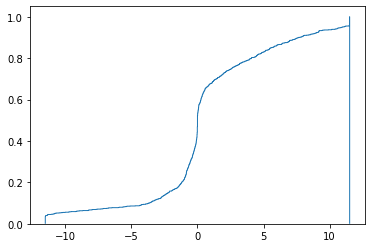

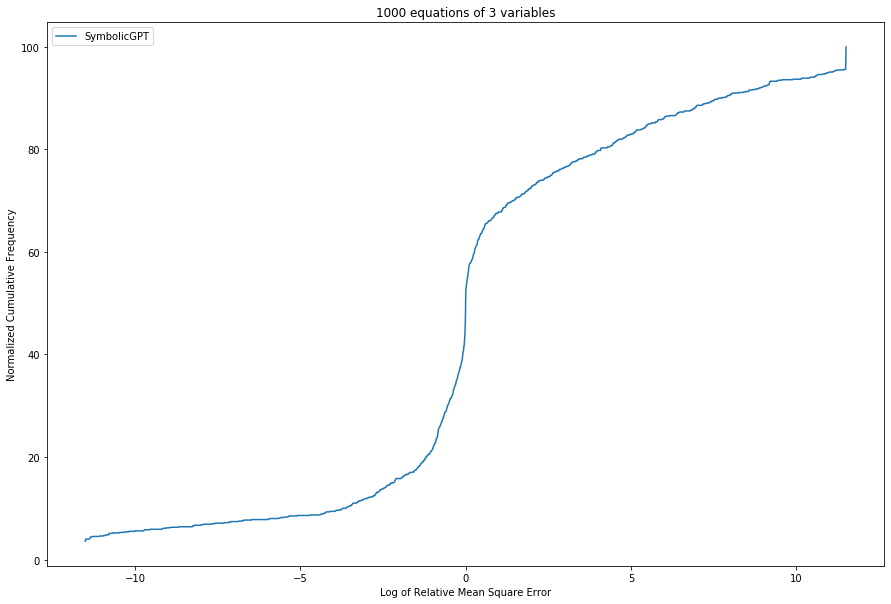

In [17]:
# plot the error frequency for model comparison
from matplotlib import pyplot as plt
num_eqns = len(resultDict[fName]['SymbolicGPT'])
num_vars = pconf.numberofVars

models = list(key for key in resultDict[fName].keys() if len(resultDict[fName][key])==num_eqns)
lists_of_error_scores = [resultDict[fName][key] for key in models if len(resultDict[fName][key])==num_eqns]
linestyles = ["-","dashdot","dotted","--"]

eps = 0.00001
y, x, _ = plt.hist([np.log([max(min(x+eps, 1e5),1e-5) for x in e]) for e in lists_of_error_scores],
                   label=models,
                   cumulative=True, 
                   histtype="step", 
                   bins=2000, 
                   density=True,
                   log=False)
y = np.expand_dims(y,0)
plt.figure(figsize=(15, 10))

for idx, m in enumerate(models): 
    plt.plot(x[:-1], 
           y[idx] * 100, 
           linestyle=linestyles[idx], 
           label=m)

plt.legend(loc="upper left")
plt.title("{} equations of {} variables".format(num_eqns, num_vars))
plt.xlabel("Log of Relative Mean Square Error")
plt.ylabel("Normalized Cumulative Frequency")

name = '{}.png'.format(fName)
plt.savefig(name)

In [ ]:
# benchmarks